In [1]:
import numpy as np
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
# dynamics definition
numPlayers = 4;
T = 10;
A = np.eye(2);
B = np.zeros((2, 1, numPlayers))
B[:,:,0] = np.array([[1], [0]]);
B[:,:,1] = np.array([[1], [-1]])/np.sqrt(2);
B[:,:,2] = np.array([[1], [1]])/np.sqrt(2);
B[:,:,3] = np.array([[0], [-1]]);
G = np.zeros((2*T, T*1 -1, numPlayers)); # 2 is the row dim of B, 1 is the column dim of B
H = np.zeros((T*2, 2));
for p in range(numPlayers):
    for col in range(T):
        Abar = np.eye(2); row=col+1;
        while row < T:
            G[row*2: (row+1)*2, col, p] = np.squeeze(Abar.dot(B[:,:,p]));
            if p == 0:
                H[col*2:(col+1)*2,:] = 1.0*Abar;
            Abar  = Abar.dot(A);
            row += 1;
        if p == 0:
            H[col*2:(col+1)*2,:] = 1.0*Abar;
Rscaler = 10.;
Q = np.eye(2);
R = Rscaler*np.eye(1);
print (G[:,:,3])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.]]


In [3]:
# derive the step sizes
J = np.zeros(((T-1)*numPlayers,(T-1)*numPlayers));
diagQ = np.eye(2*T); diagR = Rscaler*np.eye(T-1);

for i in range(T):
    diagQ[i*2: 2*(i+1), 2*i: 2*(i+1)] = Q;
    if i < T-1:
        diagR[i: (i+1), i: (i+1)] = R;
    
for i in range(numPlayers):
    for j in range(numPlayers):
        J[(T-1)*i:(T-1)*(i+1), (T-1)*j:(T-1)*(j+1)]  = G[:,:,i].T.dot(diagQ).dot(G[:,:,j]);
        if i == j:
            J[(T-1)*i:(T-1)*(i+1), (T-1)*i:(T-1)*(i+1)] += diagR;
S = 0.5*(J + J.T);  
eigS, eigVecS = np.linalg.eig(S.T.dot(S));
# print (eigS);
alpha = np.min(eigS); 
eigJ, eigVecJ = np.linalg.eig(J.T.dot(J));
beta = np.max(eigJ);
gammai = 3*np.sqrt(alpha)/beta;
# gammai= alpha/beta;

print (gammai)
dim, dim2 = J.shape;
barA = np.eye(dim) - gammai*J; 
w, v = np.linalg.eig(barA);
print (w)            


(0.00432130085556121+0j)
[0.6399458 +0.j 0.92093338+0.j 0.6399458 +0.j 0.94956441+0.j
 0.92093338+0.j 0.94339668+0.j 0.94339668+0.j 0.94956441+0.j
 0.95207672+0.j 0.95207672+0.j 0.95331742+0.j 0.95331742+0.j
 0.95399356+0.j 0.95399356+0.j 0.95456618+0.j 0.95456618+0.j
 0.9543717 +0.j 0.9543717 +0.j 0.95678699+0.j 0.95678699+0.j
 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j
 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j
 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j
 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j 0.95678699+0.j]


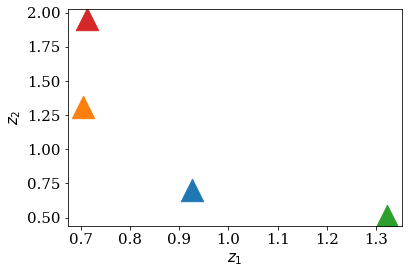

In [26]:
K = 100; # number of times to iterate
# run gradient dynamics
x0 = np.random.rand((2)) + np.array([-0.5, -0.5]);
ut = np.zeros((numPlayers*(T-1),K));
Jt = np.zeros((K, numPlayers));
ut[:,0] = np.random.rand((numPlayers*(T-1)));

xt = np.zeros((T*2, K));
xDest = 2*np.random.rand((2*numPlayers));
xTarget = np.zeros((T*2, numPlayers));
for p in range(numPlayers):
    xTarget[:,p] = np.repeat(xDest[2*p:2*(p+1)], T);
    Hstacked = np.zeros((numPlayers*(T-1), 2));
offSetStacked = np.zeros((numPlayers*(T-1)));
for p in range(numPlayers):
    Hstacked[p*(T-1):(p+1)*(T-1), :] = G[:, :, p].T.dot(diagQ).dot(H);
    offSetStacked[p*(T-1):(p+1)*(T-1)] = G[:, :, p].T.dot(xTarget[:,p]);
plt.figure();
targetSize = 500;
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.scatter(xDest[0], xDest[1], marker = '^', s = targetSize)
plt.scatter(xDest[1], xDest[2], marker = '^', s = targetSize)
plt.scatter(xDest[3], xDest[4], marker = '^', s = targetSize)
plt.scatter(xDest[5], xDest[6], marker = '^', s = targetSize)

In [27]:
#------------------------ undisturbed version ------------------------
for k in range(K):
    # the actual gradient descent on u
    if k> 0:
        ut[:, k] = barA.dot(ut[:,k-1]) - gammai*Hstacked.dot(x0) + gammai*offSetStacked; 
    
    # calculate trajectory at current control
    xt[:,k] = H.dot(x0);
    for p in range(numPlayers):
#         print((p+1)*T)
        xt[:,k] += G[:,:,p].dot(ut[p*(T-1):(p+1)*(T-1),k]);
    
    # calculate total LQR cost at current control
    for p in range(numPlayers):  
#         print(p+1)
        Jt[k,p] = 0.5*(xt[:,k]-xTarget[:,p]).T.dot(diagQ).dot(xt[:,k]-xTarget[:,p]) + 0.5*ut[p*(T-1):(p+1)*(T-1), k].T.dot(diagR).dot(ut[p*(T-1):(p+1)*(T-1), k]); 

ut_undisturbed = 1.*ut;
xt_undisturbed = 1.*xt;
Jt_undisturbed = 1.*Jt;

C:\Users\craba\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [31]:
Samples = 100;
error = np.zeros((4, Samples));
ut = np.zeros((numPlayers*(T-1),K, Samples));
#------------------------ noisy version ------------------------#
# plt.figure();
for sample in range(Samples):
    for k in range(K):
        # the actual gradient descent on u
        if k > 0:
            ut[:, k,sample] = barA.dot(ut[:,k-1,sample]) - gammai*Hstacked.dot(x0) + gammai*offSetStacked; 
        else:
            ut[:, k,sample] = ut_undisturbed[:,0];
        # add noise
        disturbScaler = 1.*(sample);
        ut[0:(T-1), k,sample] = ut[0:(T-1), k,sample] + gammai*(disturbScaler*np.random.rand(T-1)- disturbScaler/2*np.ones(T-1));

        # calculate trajectory at current control
        xt[:,k] = H.dot(x0);
        for p in range(numPlayers):
    #         print((p+1)*T)
            xt[:,k] += G[:,:,p].dot(ut[p*(T-1):(p+1)*(T-1),k,sample]);

        # calculate total LQR cost at current control
        for p in range(numPlayers):  
    #         print(p+1)
            Jt[k,p] = 0.5*(xt[:,k]-xTarget[:,p]).T.dot(diagQ).dot(xt[:,k]-xTarget[:,p]) + 0.5*ut[p*(T-1):(p+1)*(T-1), k,sample].T.dot(diagR).dot(ut[p*(T-1):(p+1)*(T-1), k,sample]); 
            
            perIterError = np.linalg.norm(np.squeeze(ut[(T-1)*p:(T-1)*(p+1), :,sample]) - ut_undisturbed[(T-1)*p:(T-1)*(p+1), :], 2, axis = 0)
            error[p, sample] = np.linalg.norm(perIterError, 2);
#             if p == 3:
#                 print (perIterError)
    #     pStyle = ['-', '-', '-.', '-']
#     for p in range(numPlayers):
# #         print (np.linalg.norm(ut[(T-1)*p:(T-1)*(p+1), :] - ut_undisturbed[(T-1)*p:(T-1)*(p+1), :], 2, axis = 0))
#         plt.plot(np.linspace(0,K,K), np.linalg.norm(ut[(T-1)*p:(T-1)*(p+1), :] - ut_undisturbed[(T-1)*p:(T-1)*(p+1), :], 2, axis = 0), pStyle[p], linewidth = 2)
#     plt.grid();
#     plt.xlabel('Learning Iteration (k)')
#     plt.ylabel('$\| u_i^k - w_i^k\|_2$');
#     plt.yscale('log')
#     plt.show()


C:\Users\craba\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
C:\Users\craba\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


In [11]:
Kk = K-1;
print (np.sum(abs(ut_undisturbed[::4, Kk] - ut[::4, Kk])))
print (ut.shape)

print ("---------- Player four ----------")
print (np.sum(abs(ut[3*T:4*T-1, Kk] - ut_undisturbed[3*T:4*T-1, Kk])))
print (ut[3*T:4*T-1, Kk])
print (ut_undisturbed[3*T:4*T-1, Kk])

ValueError: operands could not be broadcast together with shapes (9,) (9,100) 

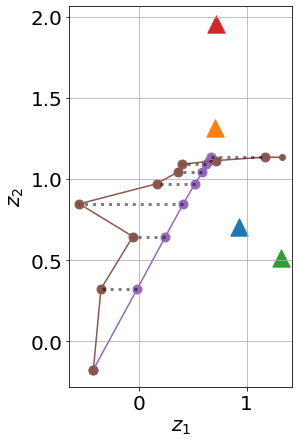

In [32]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

rc('font', **font)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b'];
fig, axis = plt.subplots(1,figsize=(4,7));
axs = [axis];
# for p in range(numPlayers):
#     axs[1].plot(np.linspace(0,K,K), 
#              np.linalg.norm(ut[(T-1)*p:(T-1)*(p+1), :] - ut_undisturbed[(T-1)*p:(T-1)*(p+1), :], 2, axis = 0), 
#              pStyle[p], 
#              linewidth = 2);
# axs[1].set_yscale('log');
# axs[1].set_xlabel('Learning Iteration (k)')
# axs[1].set_ylabel('$\| u_i^k - w_i^k\|_2$');
# axs[1].grid();
targetSize = 300;
transparency = 1.;
axs[0].scatter(xDest[0], xDest[1], marker = '^', s = targetSize, alpha = transparency)
axs[0].scatter(xDest[1], xDest[2], marker = '^', s = targetSize, alpha = transparency)
axs[0].scatter(xDest[3], xDest[4], marker = '^', s = targetSize, alpha = transparency)
axs[0].scatter(xDest[5], xDest[6], marker = '^', s = targetSize, alpha = transparency)

axs[0].grid(); 
# plt.legend();
Kk = K-1;
# color = colors[0];
# plt.scatter(xt_undisturbed[2*i], xt_undisturbed[2*i+1], color=color, s = 80, label = str(i));
axs[0].plot(xt_undisturbed[::2, Kk], xt_undisturbed[1::2, Kk], 'o-', color=colors[4], label = str(i));
axs[0].plot(xt[::2, Kk], xt[1::2, Kk], 'o-', color=colors[5], label = str(i));
for i in range(T-1):
    arrowScale = 8.;
    offset = 0.05;
#     axs[0].arrow(xt_undisturbed[2*i, Kk], 
#               xt_undisturbed[2*i+1, Kk]-offset,  
#               B[0,0,3]*ut_undisturbed[3*(T-1)+ i, Kk]*arrowScale, 
#               B[1,0,3]*ut_undisturbed[3*(T-1)+ i, Kk]*arrowScale,  
#               color = colors[4],
#               width = 0.015, 
#               head_width = 0.05,
#               head_starts_at_zero = True, 
#               length_includes_head = True,
#               overhang = 0.3,
#               alpha = 0.7);
#     axs[0].arrow(xt[2*i, Kk], 
#               xt[2*i+1, Kk] - offset,  
#               B[0,0,3]*ut[3*(T-1)+ i, Kk]*arrowScale, 
#               B[1,0,3]*ut[3*(T-1)+ i, Kk]*arrowScale,  
#               color = colors[5],
#               width = 0.015, 
#               head_width = 0.05,
#               head_starts_at_zero = True, 
#               length_includes_head = True,
#               overhang = 0.3,
#               alpha = 0.7);
    
    axs[0].scatter(xt_undisturbed[2*i, Kk], xt_undisturbed[2*i+1, Kk], color=colors[4], s = 80, label = str(i));
    axs[0].scatter(xt[2*i, Kk], xt[2*i+1, Kk], color=colors[5], s = 80, label = str(i));
    axs[0].plot([xt_undisturbed[2*i, Kk], xt[2*i, Kk]], 
             [xt_undisturbed[2*i+1, Kk], xt[2*i+1, Kk]], 
             ':',
             color = (0,0,0),
             lw = 3,
             alpha  = 0.5);
    axs[0].set_xlabel('$z_1$'); axs[0].set_ylabel('$z_2$')
plt.show();

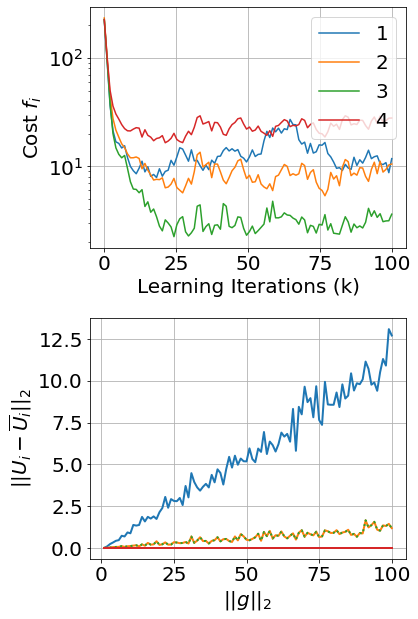

In [33]:
# fig, axis = plt.subplots(1,figsize=(3,5));
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 1}
fig, axs = plt.subplots(nrows=2,figsize=(6,9));
for p in range(numPlayers):
    axs[0].plot(np.linspace(0,K,K), Jt[:,p], label=str(p+1));
# axs[0].set_xscale('log')
axs[0].grid();
axs[0].set_yscale('log')
axs[0].set_ylabel('Cost $f_i$')
axs[0].set_xlabel('Learning Iterations (k)');
axs[0].legend()
pStyle = ['-', '-', ':', '-']

for p in range(numPlayers): 
    axs[1].plot(np.linspace(1, Samples, Samples), error[p,:], pStyle[p], linewidth = 2);
axs[1].set_xlabel('$\||g\||_2 $');
# axs[1].set_yscale('log')
axs[1].grid();
axs[1].set_ylabel('$ \|| U_i - \overline{U}_i \||_2 $');
plt.tight_layout()
plt.show()

In [11]:
plt.savefig("cost_and_control.svg")

In [ ]:
print (x0)


In [34]:
xF = xt[:,0];
print (xF);
print (H)
# uF = ut[:,K-1]
# print (uF);
# print (A)
# fig, ax = plt.subplots()
# ax.set_xlim((-1, 1));
# ax.set_ylim((-1, 2));


# plt.figure()
# for p in range(numPlayers):
#     plt.plot(np.linspace(0,K,100), Jt[:,p]);
# plt.grid()
# plt.yscale('log')
# plt.show()


[-0.42668866 -0.17398525  0.55544867 -1.32842027  1.76051732 -1.62301696
  2.6999303  -2.08235476  4.55066229 -2.44708625  6.12893465 -2.73989382
  6.60106727 -2.6792778   7.70125706 -3.63503201  9.05321415 -3.62611918
 10.65189083 -4.94942003]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


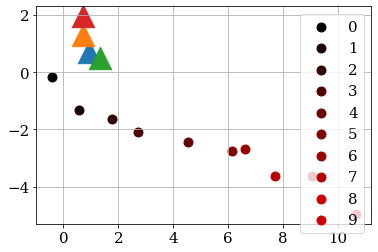

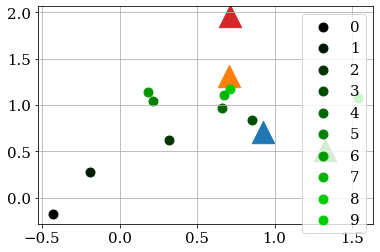

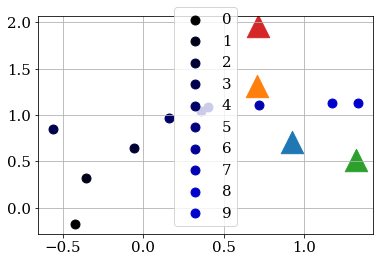

In [35]:
font = {'family' : 'serif',
        'weight' : 'roman',
        'size'   : 15}	
mpl.rc('font', **font)
def drawGame(xt, ut):
    plt.figure();
    
    for p in range(numPlayers):
        plt.arrow(x0[0], x0[1],  B[0,0,p]*ut[p], B[1, 0, p]*ut[p], color = 'g');
    plt.scatter(x0[0], x0[1], color = 'b');
    bounds = 0.5*np.array([[-1,-1,1,1], [-1,1,1,-1]]);
    plt.scatter(bounds[0,:], bounds[1,:], color = 'w');
    plt.grid();
    plt.show();
# originX = np.ones(4)*xF[2*i];
# originY = np.ones(4)*xF[2*i+1];
# dx = np.array([B[0,0,0]*ut[numPlayers*i, K-1],
#                B[0,0,1]*ut[numPlayers*i+1, K-1],
#                B[0,0,2]*ut[numPlayers*i+2, K-1],
#                B[0,0,3]*ut[numPlayers*i+3, K-1]]);
# dy = np.array([B[1,0,0]*ut[numPlayers*i, K-1],
#                B[1,0,1]*ut[numPlayers*i+1, K-1],
#                B[1,0,2]*ut[numPlayers*i+2, K-1],
#                B[1,0,3]*ut[numPlayers*i+3, K-1]]);

# print (dx)
# fig, ax = plt.subplots();
# limits = 0.2;
# ax.set_xlim((-limits, limits));
# ax.set_ylim((-limits, limits));
# plt.plot(xF[2*i], xF[2*i+1], color = 'b', label = str(i));
#     originX = np.ones(4)*xF[2*i];
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'];
# arrowSize = 
for Kk in [0, int(K/2), K-1]:
    xF = xt[:,Kk];
    plt.figure();
    targetSize = 500;
    plt.scatter(xDest[0], xDest[1], marker = '^', s = targetSize)
    plt.scatter(xDest[1], xDest[2], marker = '^', s = targetSize)
    plt.scatter(xDest[3], xDest[4], marker = '^', s = targetSize)
    plt.scatter(xDest[5], xDest[6], marker = '^', s = targetSize)
    for i in range(T-1):
        color = None;
        if Kk == 0:
            color =  (1.*i/T, 0, 0);
        elif Kk == K/2:
            color = (0, 1.*i/T, 0);
        else:
            color = (0, 0, 1.*i/T);
        arrowScale = 10./(10.);
    #     originX = np.ones(4)*xF[2*i];
    #     originY = np.ones(4)*xF[2*i+1];
        dx = np.array([B[0,0,0]*ut[numPlayers*i, Kk]*arrowScale,
                       B[0,0,1]*ut[numPlayers*i+1, Kk]*arrowScale,
                       B[0,0,2]*ut[numPlayers*i+2, Kk]*arrowScale,
                       B[0,0,3]*ut[numPlayers*i+3, Kk]*arrowScale]);
        dy = np.array([B[1,0,0]*ut[numPlayers*i, Kk]*arrowScale,
                       B[1,0,1]*ut[numPlayers*i+1, Kk]*arrowScale,
                       B[1,0,2]*ut[numPlayers*i+2, Kk]*arrowScale,
                       B[1,0,3]*ut[numPlayers*i+3, Kk]*arrowScale]);
        # plt.arrow(originX, originY,  dx, dy, color = 'g');
#         for p in range(numPlayers):
    #         print(xF[2*i], xF[2*i+1],  dx[p], dy[p])
#             plt.arrow(xF[2*i], xF[2*i+1],  dx[p], dy[p], color = colors[p],width = 0.005, head_width = 0.05,head_starts_at_zero = True);
        plt.scatter(xF[2*i], xF[2*i+1], color=color, s = 80, label = str(i));
    plt.scatter(xF[2*(T-1)], xF[2*(T-1)+1], color =color, s = 80, label = str(T - 1));
    plt.grid(); plt.legend(); 
    
plt.show();

In [10]:
xF = xt[:,T-1];
print(xF)
print(xF[::2])
print(xF[1::2])

[ 3.4606871  -0.38667836  2.81434039  0.22190575  2.16013809  0.86501419
  1.78411534  1.28251633  1.66849861  1.07792318  1.02017293  1.14453507
  1.36596099  1.39688965  1.39209143  1.35041171  2.51738303  1.41559862
  3.51999692  1.72217726]
[3.4606871  2.81434039 2.16013809 1.78411534 1.66849861 1.02017293
 1.36596099 1.39209143 2.51738303 3.51999692]
[-0.38667836  0.22190575  0.86501419  1.28251633  1.07792318  1.14453507
  1.39688965  1.35041171  1.41559862  1.72217726]


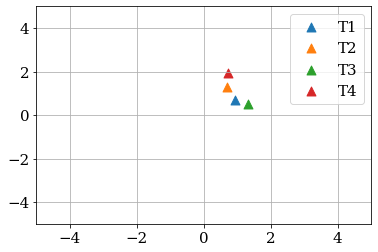

In [36]:

fig = plt.figure()
limits = 5;
ax = plt.axes(xlim=(-limits, limits), ylim=(-limits, limits));
line, = ax.plot([], [], 'o-', lw = 3, color= '#9467bd');
# p4Control = ax.plot([],[], '-', lw=2, color = '#8c564b');
plt.grid();
plt.scatter(xDest[0], xDest[1], marker = '^', s = 80, label = "T1")
plt.scatter(xDest[1], xDest[2], marker = '^', s = 80,label = "T2")
plt.scatter(xDest[3], xDest[4], marker = '^', s = 80,label = "T3")
plt.scatter(xDest[5], xDest[6], marker = '^', s = 80,label = "T4")
plt.legend()
def init(): 
    line.set_data([],[]);
#     p4Control.set_data([],[])
    return (line,)
def animate(i):
#     ax.clear();
    xF = xt[:,i];
    line.set_data(xF[::2], xF[1::2]);
#     p4Control.set_data([])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func = init, frames=K, interval = 50, blit=True);


In [37]:
HTML(anim.to_html5_video())